# Customer Segmentation Anaylsis

This is the description code for customer segmentation analysis. The original resource is from the course [Customer Segmentation Analysis in Python](https://www.datacamp.com/courses/customer-segmentation-in-python) instructed by Karolis Urbonas on [DataCamp](https://www.datacamp.com). The dataset is from UCI ML repo, which is also available from [Kaggle](https://www.kaggle.com/jihyeseo/online-retail-data-set-from-uci-ml-repo).

In [1]:
# import library
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# Import the dataset
online = pd.read_excel('Online Retail.xlsx')

In [3]:
# drop the row missing customerID
online = online[online.CustomerID.notnull()]

I'll use only the subset of the full dataset, taking 20% of samples.

In [4]:
# use a subset of full data
np.random.seed(306)
online = online.sample(frac = .2).reset_index(drop = True)
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,548670,21975,PACK OF 60 DINOSAUR CAKE CASES,1,2011-04-01 15:37:00,0.55,15356.0,United Kingdom
1,580513,23321,SMALL WHITE HEART OF WICKER,2,2011-12-04 13:59:00,1.65,14456.0,United Kingdom
2,568531,23505,PLAYING CARDS I LOVE LONDON,3,2011-09-27 13:49:00,1.25,16713.0,United Kingdom
3,544178,21411,GINGHAM HEART DOORSTOP RED,3,2011-02-16 14:40:00,4.25,14543.0,United Kingdom
4,565381,22457,NATURAL SLATE HEART CHALKBOARD,6,2011-09-02 15:23:00,2.95,16173.0,United Kingdom


In [5]:
# extract year, month and day 
online['InvoiceDay'] = online.InvoiceDate.apply(lambda x: dt.datetime(x.year, x.month, x.day))
online.InvoiceDay.head()

0   2011-04-01
1   2011-12-04
2   2011-09-27
3   2011-02-16
4   2011-09-02
Name: InvoiceDay, dtype: datetime64[ns]

In [85]:
# the number of customers
online.CustomerID.nunique()

4116

In [6]:
# Assign a minimum InvoiceDay 
online['CohortDay'] = online.groupby('CustomerID')['InvoiceDay'].transform('min')
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay
0,548670,21975,PACK OF 60 DINOSAUR CAKE CASES,1,2011-04-01 15:37:00,0.55,15356.0,United Kingdom,2011-04-01,2010-12-06
1,580513,23321,SMALL WHITE HEART OF WICKER,2,2011-12-04 13:59:00,1.65,14456.0,United Kingdom,2011-12-04,2011-07-20
2,568531,23505,PLAYING CARDS I LOVE LONDON,3,2011-09-27 13:49:00,1.25,16713.0,United Kingdom,2011-09-27,2010-12-08
3,544178,21411,GINGHAM HEART DOORSTOP RED,3,2011-02-16 14:40:00,4.25,14543.0,United Kingdom,2011-02-16,2010-12-10
4,565381,22457,NATURAL SLATE HEART CHALKBOARD,6,2011-09-02 15:23:00,2.95,16173.0,United Kingdom,2011-09-02,2011-09-02


`InvoiceDay` is the date the customr made an order and `CohortDay` is the date that each customer made the first order. Cause the `CohortDay` is made by grouping for each customer, you can understand 'cohort' as each customer. To seperate the date columns into year, month and day part by defining a funtion to extract the year, month, and day from date columns.

In [7]:
# define a funtion 
def get_date_int(col):
    year = col.dt.year
    month = col.dt.month
    day = col.dt.day
    return year, month, day

In [8]:
invoice_year, invoice_month, invoice_day = get_date_int(online.InvoiceDay)
cohort_year, cohort_month, cohort_day = get_date_int(online.CohortDay)

In [9]:
year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month
day_diff = invoice_day - cohort_day

In [10]:
month_diff.head(10)
day_diff.head(10)

0    -5
1   -16
2    19
3     6
4     0
5    -8
6     0
7    12
8     2
9    17
dtype: int64

In [11]:
# calculate the day period for each invoice date 
online['CohortIndex'] = year_diff * 365 + month_diff * 30 + day_diff 
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortIndex
0,548670,21975,PACK OF 60 DINOSAUR CAKE CASES,1,2011-04-01 15:37:00,0.55,15356.0,United Kingdom,2011-04-01,2010-12-06,120
1,580513,23321,SMALL WHITE HEART OF WICKER,2,2011-12-04 13:59:00,1.65,14456.0,United Kingdom,2011-12-04,2011-07-20,134
2,568531,23505,PLAYING CARDS I LOVE LONDON,3,2011-09-27 13:49:00,1.25,16713.0,United Kingdom,2011-09-27,2010-12-08,294
3,544178,21411,GINGHAM HEART DOORSTOP RED,3,2011-02-16 14:40:00,4.25,14543.0,United Kingdom,2011-02-16,2010-12-10,71
4,565381,22457,NATURAL SLATE HEART CHALKBOARD,6,2011-09-02 15:23:00,2.95,16173.0,United Kingdom,2011-09-02,2011-09-02,0


## 1) Cohort Matrix

Customer retention is a very useful metric to understand how many of the all customers are still active. We can also get the average price metics and see if there are any patterns across time and across cohorts.

### 1-1. Retention Rate

In [12]:
cohort_data = online.groupby(['CohortDay', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_data.head()

,CohortDay,CohortIndex,CustomerID
0,2010-12-01,0,82
1,2010-12-01,1,3
2,2010-12-01,2,2
3,2010-12-01,4,6
4,2010-12-01,5,5


In [13]:
# pivot the table  
cohort_wide = cohort_data.pivot(index = 'CohortDay', columns = 'CohortIndex', values = 'CustomerID')
cohort_wide.head(10)

CohortIndex,0,1,2,3,4,5,6,7,8,9,...,364,365,366,367,368,369,370,371,372,373
CohortDay,,,,,,,,,,,,,,,,,,,,,
2010-12-01,82.0,3.0,2.0,NaN,6.0,5.0,2.0,6.0,7.0,4.0,...,5.0,8.0,6.0,NaN,1.0,4.0,6.0,7.0,5.0,4.0
2010-12-02,83.0,NaN,NaN,NaN,1.0,3.0,3.0,6.0,4.0,NaN,...,2.0,3.0,NaN,NaN,4.0,3.0,4.0,2.0,1.0,NaN
2010-12-03,41.0,NaN,1.0,1.0,NaN,2.0,3.0,NaN,NaN,NaN,...,1.0,NaN,2.0,2.0,3.0,1.0,2.0,NaN,NaN,NaN
2010-12-05,65.0,2.0,4.0,1.0,2.0,2.0,NaN,6.0,6.0,2.0,...,7.0,2.0,3.0,3.0,3.0,2.0,NaN,NaN,NaN,NaN
2010-12-06,72.0,1.0,3.0,2.0,1.0,NaN,1.0,4.0,8.0,6.0,...,4.0,2.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-07,46.0,NaN,1.0,1.0,NaN,NaN,1.0,2.0,NaN,NaN,...,3.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-08,74.0,1.0,NaN,NaN,1.0,1.0,10.0,3.0,4.0,1.0,...,3.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-09,68.0,NaN,NaN,NaN,1.0,3.0,1.0,2.0,2.0,NaN,...,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,38.0,NaN,NaN,1.0,3.0,1.0,1.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we counted the number of customers per each the first order date and the day period, the table above is showing how many orders occured for each day period at each day. For example, the first row is showing customers who's first order occured at the 1st of DEC, 2010 and each coluns are showing how many reorders of this people are. You can see that the numbers are decresaing in a exponential destribution. This could be seen with the plot with heatmap.

Before plotting, change the values in a proportional form. I will divide the values by the first cohort value so that we can easily contrast the decreasing percentage for each date.

In [14]:
# get the proportional values of the numbers per row
cohort_sizes = cohort_wide.iloc[:, 0]
retention = cohort_wide.divide(cohort_sizes, axis = 0)

retention.round(3).head(10)

CohortIndex,0,1,2,3,4,5,6,7,8,9,...,364,365,366,367,368,369,370,371,372,373
CohortDay,,,,,,,,,,,,,,,,,,,,,
2010-12-01,1.0,0.037,0.024,NaN,0.073,0.061,0.024,0.073,0.085,0.049,...,0.061,0.098,0.073,NaN,0.012,0.049,0.073,0.085,0.061,0.049
2010-12-02,1.0,NaN,NaN,NaN,0.012,0.036,0.036,0.072,0.048,NaN,...,0.024,0.036,NaN,NaN,0.048,0.036,0.048,0.024,0.012,NaN
2010-12-03,1.0,NaN,0.024,0.024,NaN,0.049,0.073,NaN,NaN,NaN,...,0.024,NaN,0.049,0.049,0.073,0.024,0.049,NaN,NaN,NaN
2010-12-05,1.0,0.031,0.062,0.015,0.031,0.031,NaN,0.092,0.092,0.031,...,0.108,0.031,0.046,0.046,0.046,0.031,NaN,NaN,NaN,NaN
2010-12-06,1.0,0.014,0.042,0.028,0.014,NaN,0.014,0.056,0.111,0.083,...,0.056,0.028,0.069,0.042,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-07,1.0,NaN,0.022,0.022,NaN,NaN,0.022,0.043,NaN,NaN,...,0.065,0.130,0.065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-08,1.0,0.014,NaN,NaN,0.014,0.014,0.135,0.041,0.054,0.014,...,0.041,0.054,0.027,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-09,1.0,NaN,NaN,NaN,0.015,0.044,0.015,0.029,0.029,NaN,...,0.059,0.015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,1.0,NaN,NaN,0.026,0.079,0.026,0.026,0.079,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1-2. Average Price

In [15]:
cohort_data2 = online.groupby(['CohortDay', 'CohortIndex'])['UnitPrice'].mean().reset_index()
cohort_data2.head()

,CohortDay,CohortIndex,UnitPrice
0,2010-12-01,0,3.526332
1,2010-12-01,1,4.094222
2,2010-12-01,2,3.433913
3,2010-12-01,4,4.250233
4,2010-12-01,5,3.344545


In [16]:
# pivot the table 
cohort_wide2 = cohort_data2.pivot(index= 'CohortDay', columns= 'CohortIndex', values= 'UnitPrice').round(1)
cohort_wide2.head(10)

CohortIndex,0,1,2,3,4,5,6,7,8,9,...,364,365,366,367,368,369,370,371,372,373
CohortDay,,,,,,,,,,,,,,,,,,,,,
2010-12-01,3.5,4.1,3.4,NaN,4.3,3.3,2.6,3.2,3.1,4.6,...,3.4,2.9,4.2,NaN,2.0,1.9,1.9,3.3,2.4,2.9
2010-12-02,2.9,NaN,NaN,NaN,3.4,1.8,2.9,4.4,2.9,NaN,...,4.6,3.9,NaN,NaN,3.3,3.7,2.9,2.4,2.5,NaN
2010-12-03,3.0,NaN,1.8,2.6,NaN,3.1,4.5,NaN,NaN,NaN,...,2.7,NaN,1.9,1.8,1.9,3.6,2.4,NaN,NaN,NaN
2010-12-05,2.9,3.7,5.3,2.0,3.7,2.5,NaN,3.4,3.0,4.8,...,3.0,1.8,3.4,3.1,2.6,2.9,NaN,NaN,NaN,NaN
2010-12-06,2.9,3.0,1.5,1.2,7.4,NaN,1.4,4.5,3.4,3.6,...,3.9,1.2,3.5,3.9,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-07,3.3,NaN,2.8,3.8,NaN,NaN,3.1,2.7,NaN,NaN,...,1.9,1.8,4.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-08,3.4,2.1,NaN,NaN,1.0,1.0,4.4,2.4,2.5,3.8,...,2.7,2.5,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-09,3.1,NaN,NaN,NaN,3.0,2.2,2.3,3.6,3.7,NaN,...,1.6,4.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,3.0,NaN,NaN,2.0,2.4,7.4,4.5,4.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2) RFM Segmentation

RFM (Recency, Frequency, Monetary) is a very Simple Technique that we can apply it very easy and get the super useful analysis for our Customer Segmentation. Recency is days since the customers made the last purchase and by definition, the lower it is the better. Frequency is the number of transaction in the last 12 months. Monetary value is the total amout of money the customers spent in the last 12 months.

In [17]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortIndex
0,548670,21975,PACK OF 60 DINOSAUR CAKE CASES,1,2011-04-01 15:37:00,0.55,15356.0,United Kingdom,2011-04-01,2010-12-06,120
1,580513,23321,SMALL WHITE HEART OF WICKER,2,2011-12-04 13:59:00,1.65,14456.0,United Kingdom,2011-12-04,2011-07-20,134
2,568531,23505,PLAYING CARDS I LOVE LONDON,3,2011-09-27 13:49:00,1.25,16713.0,United Kingdom,2011-09-27,2010-12-08,294
3,544178,21411,GINGHAM HEART DOORSTOP RED,3,2011-02-16 14:40:00,4.25,14543.0,United Kingdom,2011-02-16,2010-12-10,71
4,565381,22457,NATURAL SLATE HEART CHALKBOARD,6,2011-09-02 15:23:00,2.95,16173.0,United Kingdom,2011-09-02,2011-09-02,0


Let's create a new dataframe with RFM values.

In [18]:
# Create total spend dataframe
online['TotalSum'] = online.Quantity * online.UnitPrice

online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortIndex,TotalSum
0,548670,21975,PACK OF 60 DINOSAUR CAKE CASES,1,2011-04-01 15:37:00,0.55,15356.0,United Kingdom,2011-04-01,2010-12-06,120,0.55
1,580513,23321,SMALL WHITE HEART OF WICKER,2,2011-12-04 13:59:00,1.65,14456.0,United Kingdom,2011-12-04,2011-07-20,134,3.30
2,568531,23505,PLAYING CARDS I LOVE LONDON,3,2011-09-27 13:49:00,1.25,16713.0,United Kingdom,2011-09-27,2010-12-08,294,3.75
3,544178,21411,GINGHAM HEART DOORSTOP RED,3,2011-02-16 14:40:00,4.25,14543.0,United Kingdom,2011-02-16,2010-12-10,71,12.75
4,565381,22457,NATURAL SLATE HEART CHALKBOARD,6,2011-09-02 15:23:00,2.95,16173.0,United Kingdom,2011-09-02,2011-09-02,0,17.70


In [19]:
print('Min : {}, Max : {}'.format(min(online.InvoiceDay), max(online.InvoiceDay)))

Min : 2010-12-01 00:00:00, Max : 2011-12-09 00:00:00


The last day of purchase in total is 09 DEC, 2011. To calculate the day periods, let's set one day after the last one, or 10 DEC as a snapshot date. We will cound the diff days with snapshot_date.

In [20]:
snapshot_date = max(online.InvoiceDay) + dt.timedelta(1)

In [21]:
# calculate RFM values
datamart = online.groupby('CustomerID').agg({
    'InvoiceDate' : lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo' : 'count', 
    'TotalSum' : 'sum'})

In [22]:
# renmae the columns
datamart.rename(columns = {'InvoiceDate' : 'Recency', 
                           'InvoiceNo' : 'Frequency', 
                           'TotalSum' : 'MonetaryValue'}, inplace = True)

datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,2,29,641.00
12348.0,248,3,400.00
12349.0,18,16,324.42
12350.0,310,5,110.40
12352.0,36,17,621.28


As the three columns are grouped by customers and count the days from the max date value, `Recency` is the days since the last purchase of a customer. `Frequency` is the number of purchases of a customer and `MonetaryValue` is the total amount of spend of a customer.  

### 2-1. RFM quartiles 

Let's group the customers based on `Recency` and `Frequency`. We will use quantile values to get three equal percentile groups an then make three separate gruops. As the lower `Recency` value is the better, we will label them in decreasing order.      

In [23]:
# create labels and assign them to tree percntile groups 
r_labels = range(4, 0, -1)
r_groups = pd.qcut(datamart.Recency, q = 4, labels = r_labels)

f_labels = range(1, 5)
f_groups = pd.qcut(datamart.Frequency, q = 4, labels = f_labels)

m_labels = range(1, 5)
m_groups = pd.qcut(datamart.MonetaryValue, q = 4, labels = m_labels)

m_groups.head()

CustomerID
12347.0    4
12348.0    4
12349.0    3
12350.0    2
12352.0    4
Name: MonetaryValue, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

In [24]:
# make a new column for group labels
datamart['R'] = r_groups.values
datamart['F'] = f_groups.values
datamart['M'] = m_groups.values

In [25]:
# sum up the three columns
datamart['RFM_Segment'] = datamart.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
datamart['RFM_Score'] = datamart[['R', 'F', 'M']].sum(axis = 1)
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12347.0,2,29,641.00,4,4,4,444,12.0
12348.0,248,3,400.00,1,1,4,114,6.0
12349.0,18,16,324.42,4,3,3,433,10.0
12350.0,310,5,110.40,1,2,2,122,5.0
12352.0,36,17,621.28,3,3,4,334,10.0


### 2-2. RFM Segment Analysis

With this value, we can go further analysis such as what is the average values for each RFM values or leveling
customers in total RFM score.

In [26]:
# calculate averae values for each RFM_score
datamart_agg = datamart.groupby('RFM_Score').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'MonetaryValue' : ['mean', 'count']
})

datamart_agg.round(1).head()

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3.0         264.3       2.1          21.4   386
4.0         173.4       3.0          44.2   384
5.0         142.5       4.7          75.8   487
6.0         100.1       6.2         212.2   438
7.0          82.8       9.1         168.4   429

In [27]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'Top'
    elif (df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10):
        return 'Mid'
    else:
        return 'Low'

In [28]:
# Create a new variable RFM_Level
datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12347.0,2,29,641.00,4,4,4,444,12.0,Top
12348.0,248,3,400.00,1,1,4,114,6.0,Mid
12349.0,18,16,324.42,4,3,3,433,10.0,Top
12350.0,310,5,110.40,1,2,2,122,5.0,Low
12352.0,36,17,621.28,3,3,4,334,10.0,Top


## 3) Customer Segmentation with Kmeans

We can also apply Kmeans clustering with RFM values. As Kmeans clustering require data to be normalized and has a symmetric distribution, preprocessing process in scale is needed. 

### 3-1. Preprocessing 

C:\Users\jjone\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


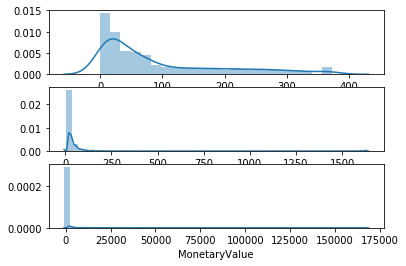

In [29]:
# plot the distribution of RFM values
plt.subplot(3, 1, 1); sns.distplot(datamart.Recency)
plt.subplot(3, 1, 2); sns.distplot(datamart.Frequency)
plt.subplot(3, 1, 3); sns.distplot(datamart.MonetaryValue)

plt.show()

As you can see above, the values are skewed and need to be normalized. 

In [30]:
# summary values
datamart.describe()

,Recency,Frequency,MonetaryValue,RFM_Score
count,4121.000000,4121.000000,4121.000000,4121.000000
mean,94.147780,19.744237,455.239765,7.439456
std,100.962757,47.947383,3199.513146,2.825471
min,0.000000,1.000000,-817.510000,3.000000
25%,18.000000,4.000000,57.500000,5.000000
50%,51.000000,9.000000,137.160000,7.000000
75%,149.000000,22.000000,340.930000,10.000000
max,373.000000,1634.000000,168471.250000,12.000000


Due to the zero or negative values in `Recency` and `MonetaryValue`, we need to set them 1 before log transformation and scaling.

In [31]:
# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x

In [32]:
# apply the function to Recency and MonetaryValue column 
datamart['Recency'] = [neg_to_zero(x) for x in datamart.Recency]
datamart['MonetaryValue'] = [neg_to_zero(x) for x in datamart.MonetaryValue]
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12347.0,2,29,641.00,4,4,4,444,12.0,Top
12348.0,248,3,400.00,1,1,4,114,6.0,Mid
12349.0,18,16,324.42,4,3,3,433,10.0,Top
12350.0,310,5,110.40,1,2,2,122,5.0,Low
12352.0,36,17,621.28,3,3,4,334,10.0,Top


In [33]:
# unskew the data
rfm_log = datamart[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log, axis = 1).round(3)
rfm_log.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,0.693,3.367,6.463
12348.0,5.513,1.099,5.991
12349.0,2.890,2.773,5.782
12350.0,5.737,1.609,4.704
12352.0,3.584,2.833,6.432


In [34]:
rfm_log.describe()

,Recency,Frequency,MonetaryValue
count,4121.000000,4121.000000,4121.000000
mean,3.772734,2.213949,4.921445
std,1.463306,1.211813,1.420750
min,0.000000,0.000000,-0.799000
25%,2.890000,1.386000,4.052000
50%,3.932000,2.197000,4.921000
75%,5.004000,3.091000,5.832000
max,5.922000,7.399000,12.035000


In [35]:
# scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [36]:
# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = datamart.index, columns = rfm_log.columns)
rfm_scaled.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,-2.104896,0.951625,1.085161
12348.0,1.189415,-0.920178,0.752902
12349.0,-0.603319,0.461391,0.605778
12350.0,1.342511,-0.499270,-0.153068
12352.0,-0.128993,0.510909,1.063339


C:\Users\jjone\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


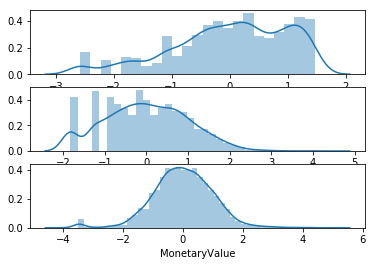

In [37]:
# plot the distribution of RFM values
plt.subplot(3, 1, 1); sns.distplot(rfm_scaled.Recency)
plt.subplot(3, 1, 2); sns.distplot(rfm_scaled.Frequency)
plt.subplot(3, 1, 3); sns.distplot(rfm_scaled.MonetaryValue)

plt.show()

### 3-2. K-means clustering

With the Elbow method, we can get the optimal number of clusters.  

In [38]:
# initiate an empty dictionary
wcss = {}

# Elbow method with for loop
for i in range(1, 21):
    kmeans = KMeans(n_clusters= i, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm_scaled)
    wcss[i] = kmeans.inertia_

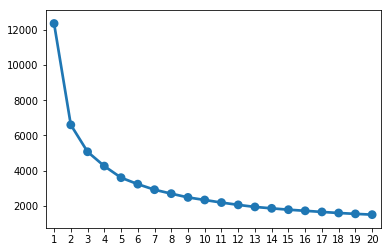

In [39]:
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.show()

In [40]:
# choose n_clusters = 4
clus = KMeans(n_clusters= 4, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [41]:
# Assign the clusters to datamart
datamart['Cluster'] = clus.labels_
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level,Cluster
CustomerID,,,,,,,,,,
12347.0,2,29,641.00,4,4,4,444,12.0,Top,2
12348.0,248,3,400.00,1,1,4,114,6.0,Mid,1
12349.0,18,16,324.42,4,3,3,433,10.0,Top,1
12350.0,310,5,110.40,1,2,2,122,5.0,Low,0
12352.0,36,17,621.28,3,3,4,334,10.0,Top,1


### 3-3. Visualization

Now we can go further analysis with this label as we did with RFM quantils.

In [42]:
datamart.groupby('Cluster').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'MonetaryValue' : ['mean', 'count']
}).round(3)

Recency Frequency MonetaryValue      
            mean      mean          mean count
Cluster                                       
0        182.782     3.186        52.478  1236
1        106.371    15.879       315.695  1288
2         13.094    59.665      1570.621   842
3         18.625     8.925       116.571   755

In marketing, snail plot and heatmap are often used plot for visualization. I'll use the `rfm_scaled` dataframe with normalized rfm values for the plot.

In [43]:
# assign cluster column 
rfm_scaled['Cluster'] = clus.labels_
rfm_scaled.reset_index(inplace = True)

In [44]:
rfm_scaled.head()

,CustomerID,Recency,Frequency,MonetaryValue,Cluster
0,12347.0,-2.104896,0.951625,1.085161,2
1,12348.0,1.189415,-0.920178,0.752902,1
2,12349.0,-0.603319,0.461391,0.605778,1
3,12350.0,1.342511,-0.499270,-0.153068,0
4,12352.0,-0.128993,0.510909,1.063339,1


In [45]:
# melt the dataframe
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['CustomerID', 'Cluster'], var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,CustomerID,Cluster,Metrics,Value
0,12347.0,2,Recency,-2.104896
1,12348.0,1,Recency,1.189415
2,12349.0,1,Recency,-0.603319
3,12350.0,0,Recency,1.342511
4,12352.0,1,Recency,-0.128993


C:\Users\jjone\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


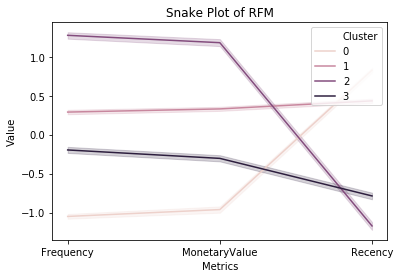

In [46]:
# a snake plot
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'Cluster', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

Heatmap is efficient for comparing the standardized values. 

In [47]:
# the mean value for each cluster
cluster_avg = datamart.groupby('Cluster').mean().iloc[:, 0:3]
cluster_avg.head()

,Recency,Frequency,MonetaryValue
Cluster,,,
0,182.782362,3.186084,52.477872
1,106.371118,15.878882,315.694961
2,13.093824,59.665083,1570.620784
3,18.625166,8.924503,116.571457


In [48]:
# the mean value in total 
total_avg = datamart.iloc[:, 0:3].mean()
total_avg

Recency           94.154817
Frequency         19.744237
MonetaryValue    456.673601
dtype: float64

In [49]:
# the proportional mean value
prop_rfm = cluster_avg/total_avg - 1
prop_rfm

,Recency,Frequency,MonetaryValue
Cluster,,,
0,0.941296,-0.838632,-0.885087
1,0.129747,-0.195771,-0.308708
2,-0.860933,2.021899,2.439263
3,-0.802186,-0.547995,-0.744738


[]

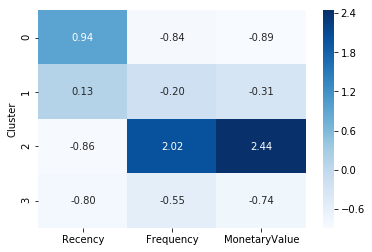

In [50]:
# heatmap
sns.heatmap(prop_rfm, cmap= 'Blues', fmt= '.2f', annot = True)
plt.plot()